In [114]:
import pandas as pd
import os

df = pd.read_pickle("../tmp/engineered_features.pkl")

for col in df.columns:
    if  df[col].dtype.name == 'category' or df[col].nunique() < 20:
        print(f"\n🟦 Column: {col} (Categorical)")
        counts = df[col].value_counts(normalize=True) * 100  
        print(counts.round(2).astype(str) + ' %') 



🟦 Column: comments_disabled (Categorical)
comments_disabled
0    98.45 %
1     1.55 %
Name: proportion, dtype: object

🟦 Column: ratings_disabled (Categorical)
ratings_disabled
0    99.59 %
1     0.41 %
Name: proportion, dtype: object

🟦 Column: video_error_or_removed (Categorical)
video_error_or_removed
0    99.94 %
1     0.06 %
Name: proportion, dtype: object

🟦 Column: cat_1 (Categorical)
cat_1
0.0    94.27 %
1.0     5.73 %
Name: proportion, dtype: object

🟦 Column: cat_2 (Categorical)
cat_2
0.0    99.06 %
1.0     0.94 %
Name: proportion, dtype: object

🟦 Column: cat_10 (Categorical)
cat_10
0.0    84.19 %
1.0    15.81 %
Name: proportion, dtype: object

🟦 Column: cat_15 (Categorical)
cat_15
0.0    97.75 %
1.0     2.25 %
Name: proportion, dtype: object

🟦 Column: cat_17 (Categorical)
cat_17
0.0    94.69 %
1.0     5.31 %
Name: proportion, dtype: object

🟦 Column: cat_19 (Categorical)
cat_19
0.0    99.02 %
1.0     0.98 %
Name: proportion, dtype: object

🟦 Column: cat_20 (Categorical)
c

Firstly we collect categorical columns. We define a threshold for unique values of a column. If there exist more than twenty unique values in a specific column, we consider that column as categorical attribute. Then we drop mostly constant columns since they do not contain any valuable knowledge. We observe comments_disabled, ratings_disabled and video_error_or_removed are approximately constant through all samples, thus we drop them. ( ignoring one-hot category)

In [115]:
df = df.drop(['comments_disabled','ratings_disabled', 'video_error_or_removed'], axis=1)

In [116]:
temp = df[["video_id", "channel_title", "trending_date", "views", "publish_date", "publish_hour", "likes", "dislikes", "comment_count"]]
null_percent_col = (temp.isna() | (temp == '')).mean() * 100
print("🔍 Missing values per column (%):")
print(null_percent_col.round(4).astype(str) + ' %')


🔍 Missing values per column (%):
video_id         0.0 %
channel_title    0.0 %
trending_date    0.0 %
views            0.0 %
publish_date     0.0 %
publish_hour     0.0 %
likes            0.0 %
dislikes         0.0 %
comment_count    0.0 %
dtype: object


All columns contain values in all their corresponding field.

Now we remove duplicated rows.

In [117]:
print("Before duplicated rows removal: ",len(df))
df = df.drop_duplicates()

print("After duplicated rows removal:", len(df))


Before duplicated rows removal:  40949
After duplicated rows removal: 40910


Usually social actions(view_count, likes, dislikes, comment_count) vary over several orders of magnitudeand and they are right-skewed. Apply a log transform to remove right-skewness.

In [118]:
col_name = 'likes'
original_data = df[col_name].copy()

In [129]:
numeric_attributes = list(["views", "publish_hour", "likes", "dislikes", "comment_count", "engagement_rate", "like_dislike_ratio", "tag_count"])

In [120]:
import numpy as np
df[numeric_attributes] = df[numeric_attributes].apply(lambda x: np.log1p(x))


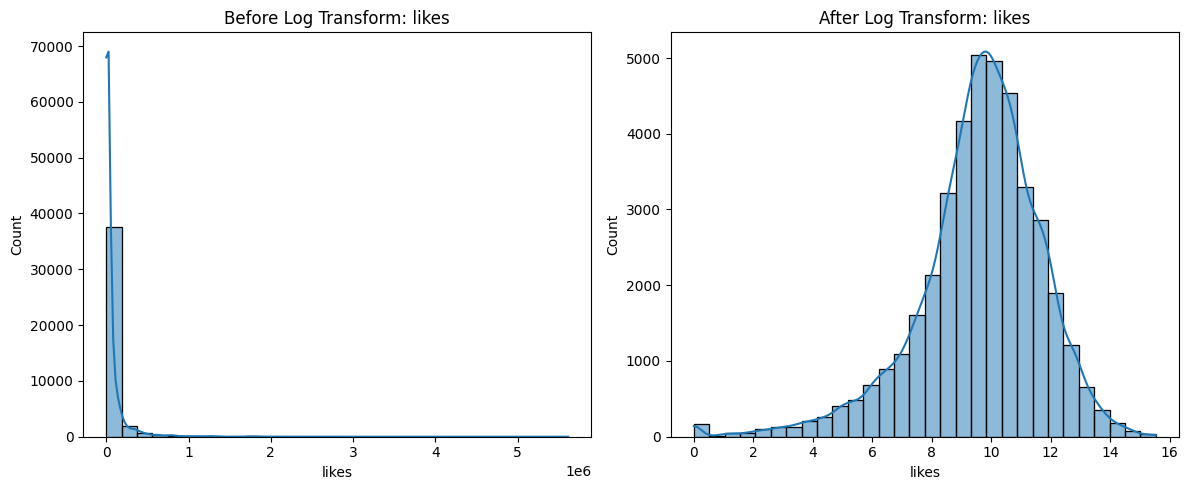

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Plot
plt.figure(figsize=(12, 5))

# Before
plt.subplot(1, 2, 1)
sns.histplot(original_data, kde=True, bins=30)
plt.title(f"Before Log Transform: {col_name}")

# After
plt.subplot(1, 2, 2)
sns.histplot(df[col_name], kde=True, bins=30)
plt.title(f"After Log Transform: {col_name}")

plt.tight_layout()
plt.show()


Then we scale values to range [0, 1] and center data (mean = 0, std = 1).

In [122]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[numeric_attributes] = scaler.fit_transform(df[numeric_attributes])

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_attributes] = scaler.fit_transform(df[numeric_attributes] )


Now lert us explore whether any pair of attributes hold correlation.

In [124]:
# Select numeric columns only
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()


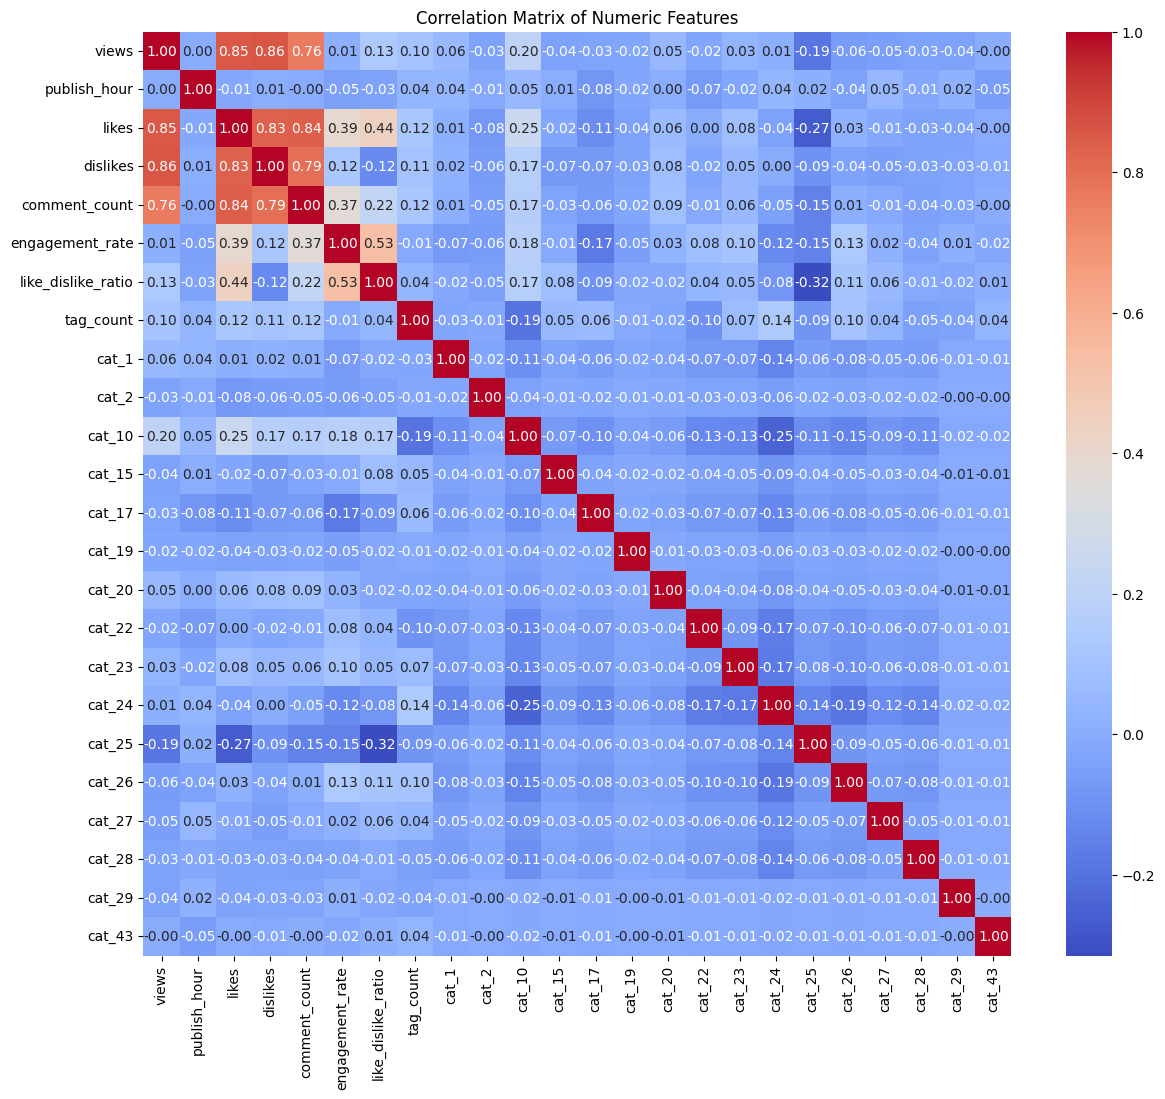

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

We can observe there are high correlations amongst likes, dislikes, comments and views. Thus we consider a threshold 80 percent. Since likes and dislikes are the ones having most correlation value with others, we drop these two lines.

In [126]:
df = df.drop(["likes", "dislikes"], axis=1)

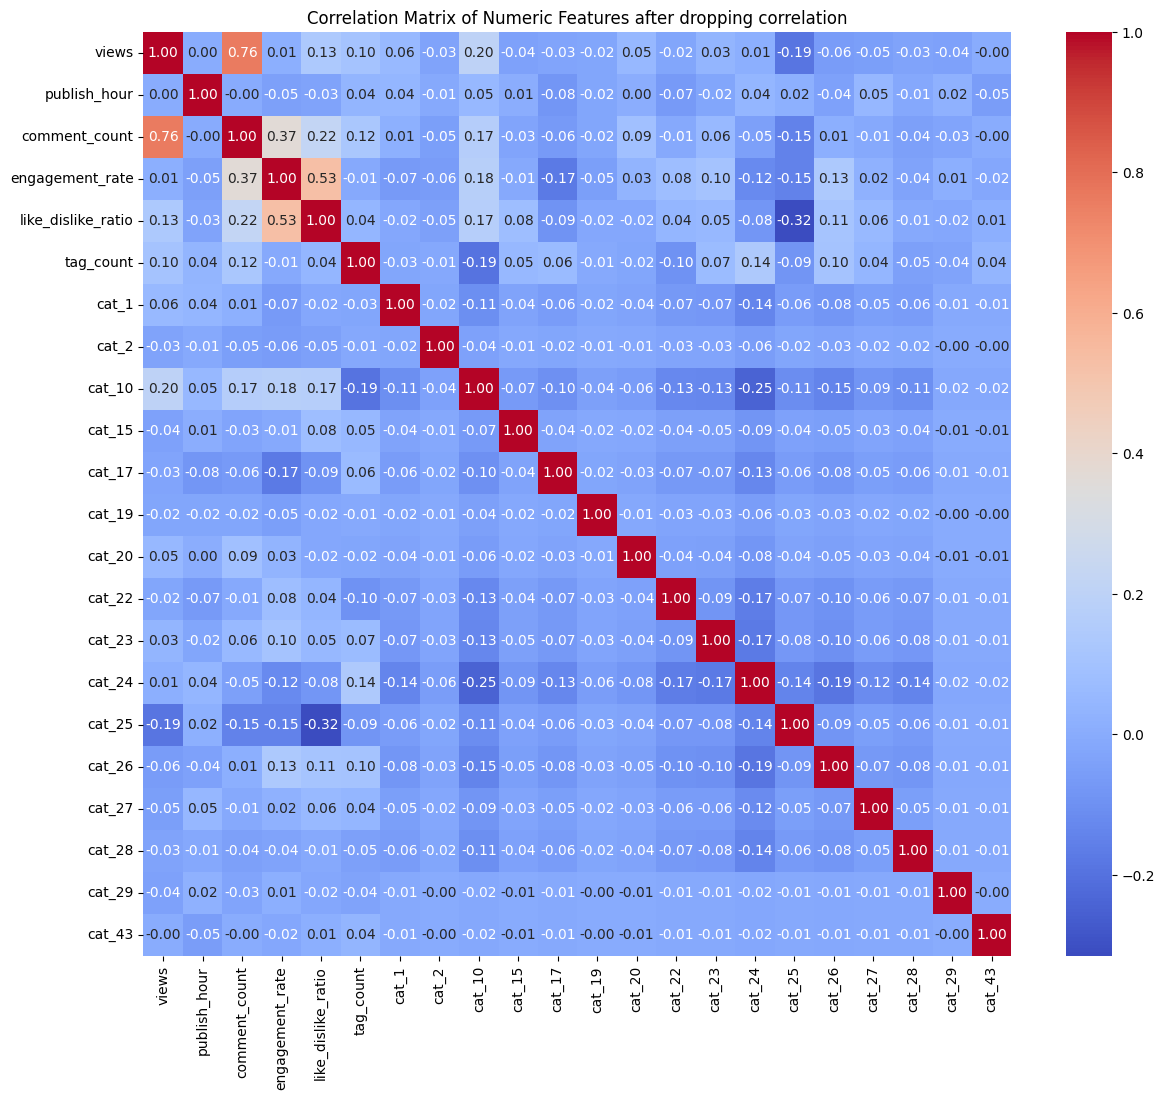

In [127]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features after dropping correlation')
plt.show()